Now you can run the previous cell to import `torch` and `make_dot`.

Replicate original script

In [1]:
import tensorflow as tf
## reduce GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
!pip install medmnist==3.0.1 \
    torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
from torchsummary import summary

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator

import torchattacks
from torchattacks import PGD, FGSM
from torch.utils.data import Subset, random_split, DataLoader
from torchvision import transforms
import torchvision
import random
import torch
import pandas as pd
from torchvision.transforms.transforms import Resize
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
## loading history
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import time


In [2]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)
print("Medmnist", medmnist.__version__)

PyTorch 2.6.0+cu124
Torchvision 0.21.0+cu124
Torchattacks 3.5.1
Numpy 2.0.2
Medmnist 3.0.1


In [3]:
### lower down sample: 1000 sample

def med3dfulldata(DataClass):
  transform = lambda x: torch.from_numpy(x).squeeze(1).float()
  train_dataset = DataClass(split='train', transform=transform, download=True)
  val_dataset = DataClass(split='val', transform=transform, download=True)
  test_dataset = DataClass(split='test', transform=transform, download=True)

  # encapsulate data into dataloader form
  train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
  return train_loader, train_loader_at_eval, test_loader

# --- Helper to create a single batch with all classes ---
def get_one_batch_with_all_classes(dataset, num_classes, batch_size=32):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    all_inputs, all_targets = [], []
    seen_classes = set()

    for x, y in loader:
        all_inputs.append(x)
        all_targets.append(y)
        seen_classes.update(y.squeeze().tolist())

        if len(seen_classes) == num_classes:
            all_inputs = torch.cat(all_inputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            return [(all_inputs, all_targets)]
    raise ValueError(f"Could not find all {num_classes} classes in the dataset.")

def data_input_loading(data_flag, BATCH_SIZE=15, lr=0.0005, NUM_EPOCHS=5, total_samples=1500, med3d = False):
    download = True
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])

    if med3d:
      train_loader, train_loader_at_eval, test_loader = med3dfulldata(DataClass)
    else:
      # preprocessing
      train_transform = transforms.Compose([
          transforms.Resize(224),
          transforms.Lambda(lambda image: image.convert('RGB')),
          torchvision.transforms.AugMix(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[.5], std=[.5])
      ])
      test_transform = transforms.Compose([
          transforms.Resize(224),
          transforms.Lambda(lambda image: image.convert('RGB')),
          transforms.ToTensor(),
          transforms.Normalize(mean=[.5], std=[.5])
      ])

      # Load full dataset first (train + test combined)
      full_dataset = DataClass(split='train', transform=train_transform, download=download)
      test_dataset_full = DataClass(split='test', transform=test_transform, download=download)
      combined_dataset = torch.utils.data.ConcatDataset([full_dataset, test_dataset_full])

      # Randomly select only total_samples items
      if total_samples > len(combined_dataset):
        total_samples = len(combined_dataset)
      indices = random.sample(range(len(combined_dataset)), total_samples)
      small_dataset = Subset(combined_dataset, indices)

      # Split into train / val / test (e.g., 70/15/15 split)
      train_size = int(0.7 * total_samples)
      val_size = int(0.15 * total_samples)
      test_size = total_samples - train_size - val_size
      train_dataset, val_dataset, test_dataset = random_split(small_dataset, [train_size, val_size, test_size])

      # Dataloaders
      train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
      train_loader_at_eval = get_one_batch_with_all_classes(train_dataset, n_classes, batch_size=2*BATCH_SIZE)
      test_loader = get_one_batch_with_all_classes(test_dataset, n_classes, batch_size=2*BATCH_SIZE)

    return data_flag, NUM_EPOCHS, BATCH_SIZE, lr, task, train_loader, train_loader_at_eval, test_loader, n_classes


In [4]:
## loading model
from MedVit3D import MedViT3D_small
from MedViT import MedViT_small

/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
def getPrecision(y_true, y_score, task, threshold=0.5):
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        y_pred = (y_score > threshold).astype(int)
        return precision_score(y_true, y_pred, average="macro", zero_division=0)
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        y_pred = (y_score > threshold).astype(int)
        return precision_score(y_true, y_pred, average="binary", zero_division=0)
    else:
        y_pred = np.argmax(y_score, axis=-1)
        return precision_score(y_true, y_pred, average="macro", zero_division=0)


def getRecall(y_true, y_score, task, threshold=0.5):
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        y_pred = (y_score > threshold).astype(int)
        return recall_score(y_true, y_pred, average="macro", zero_division=0)
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        y_pred = (y_score > threshold).astype(int)
        return recall_score(y_true, y_pred, average="binary", zero_division=0)
    else:
        y_pred = np.argmax(y_score, axis=-1)
        return recall_score(y_true, y_pred, average="macro", zero_division=0)


def getF1(y_true, y_score, task, threshold=0.5):
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        y_pred = (y_score > threshold).astype(int)
        return f1_score(y_true, y_pred, average="macro", zero_division=0)
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        y_pred = (y_score > threshold).astype(int)
        return f1_score(y_true, y_pred, average="binary", zero_division=0)
    else:
        y_pred = np.argmax(y_score, axis=-1)
        return f1_score(y_true, y_pred, average="macro", zero_division=0)

#######################################################################

# evaluation
def getAUC(y_true, y_score, task):
    """AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    """
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        auc = 0
        for i in range(y_score.shape[1]):
            label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
            auc += label_auc
        ret = auc / y_score.shape[1]
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = roc_auc_score(y_true, y_score)
    else:
        auc = 0
        for i in range(y_score.shape[1]):
            y_true_binary = (y_true == i).astype(float)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        ret = auc / y_score.shape[1]

    return ret


def getACC(y_true, y_score, task, threshold=0.5):
    """Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    """
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        y_pre = y_score > threshold
        acc = 0
        for label in range(y_true.shape[1]):
            label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
            acc += label_acc
        ret = acc / y_true.shape[1]
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = accuracy_score(y_true, y_score > threshold)
    else:
        ret = accuracy_score(y_true, np.argmax(y_score, axis=-1))

    return ret

def test(data_loader, model, criterion, task):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    data_loader = data_loader
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            total_loss += loss.item()
            num_batches += 1

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
        avg_loss = total_loss / num_batches
        ########################################################################################
        precision = getPrecision(y_true, y_score, task)
        recall = getRecall(y_true, y_score, task)
        f1 = getF1(y_true, y_score, task)

        return auc, acc ,avg_loss, precision, recall, f1 #, y_true, y_score


def load_or_initialize_model(model_class, model_name, optimizer_class, lr, momentum, n_classes, task):
    model_dir = "./history_record"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"{model_name}.pth")
    history_path = os.path.join(model_dir, f"{model_name}.csv")

    if "3d" in model_name.lower():
      model = MedViT3D_small(num_classes = n_classes).to(device)
    else:
      model = MedViT_small(num_classes = n_classes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)

    start_epoch = 0
    best_val_auc = 0
    history = {
        "train_auc": [], "train_acc": [],"train_precision": [], "train_recall": [], "train_f1": [],
        "val_auc": [], "val_acc": [],"val_precision": [], "val_recall": [], "val_f1": [],
        "train_loss": [], "val_loss": [],
        "epoch_time": []
    }

    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Loading existing model: {model_name}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = pd.read_csv(history_path).to_dict(orient='list')
        start_epoch = len(history["train_loss"])
        best_val_auc = max(history["val_auc"]) if history["val_auc"] else 0

    return model, optimizer, history, start_epoch, best_val_auc
def training_and_record(model_class,
                        model_name,
                        NUM_EPOCHS, lr,
                        momentum, train_loader,
                        train_loader_at_eval,
                        test_loader,
                        n_classes,
                        task,
                        steps):
    model, optimizer, history, start_epoch, best_val_auc = load_or_initialize_model(
        model_class, model_name, optimizer_class=torch.optim.SGD, lr=lr, momentum=momentum, n_classes = n_classes,
        task = task
    )
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    total_loss = 0
    step_count = 0  # counter for batch steps
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        print(f'\nEpoch [{epoch + 1}/{start_epoch + NUM_EPOCHS}]')
        start_time = time.time()
        model.train()

        for inputs, targets in tqdm(train_loader):
            step_count += 1
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            unique_classes = np.unique(targets.cpu().numpy())
            # print(f"Unique class in target data batch is: {unique_classes.tolist()}  | Count: {len(unique_classes)}")
            if task == 'multi-label, binary-class':
                # print("Going to multi-label, bunary-class branch")
                # Ensure targets become [B, n_classes] float
                targets = torch.nn.functional.one_hot(
                    targets.squeeze().long(), num_classes=n_classes
                ).float().to(device)
                # print("target shape of original data before loss ", targets.shape)
                # print("output shape after model, before loss: ", outputs.shape)
                loss = criterion(outputs, targets)
            else:
                # print("going to ther branch")
                targets = targets.squeeze().long()  # labels become long
                # print("target shape of original data before loss ", targets.shape)
                # print("output shape after model, before loss: ", outputs.shape)
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # stop after 20 steps per epoch
            # if step_count >= steps:
            #     print(f"Breaking after {step_count} steps in this epoch.")
            #     break

        torch.cuda.empty_cache()

        # Logging
        train_loss = total_loss / len(train_loader)
        # validation loss:  auc, acc ,avg_loss, precision, recall, f1
        val_auc, val_acc, val_loss, val_prec, val_rec, val_f1 = test(test_loader, model, criterion, task)
        # train loss
        train_auc, train_acc, train_loss, train_prec, train_rec, train_f1 = test( train_loader_at_eval, model, criterion, task)


        history["train_auc"].append(train_auc)
        history["train_acc"].append(train_acc)
        history["train_precision"].append(train_prec)
        history["train_recall"].append(train_rec)
        history["train_f1"].append(train_f1)
        history["train_loss"].append(train_loss)

        history["val_auc"].append(val_auc)
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_prec)
        history["val_recall"].append(val_rec)
        history["val_f1"].append(val_f1)
        history["val_loss"].append(val_loss)

        # Log epoch time
        epoch_time = time.time() - start_time
        history["epoch_time"].append(epoch_time)
        print(f"Epoch {epoch+1} finished in {epoch_time:.2f} seconds")

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            print("📌 New best AUC — saving model")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f"./history_record/{model_name}.pth")

        pd.DataFrame(history).to_csv(f"./history_record/{model_name}.csv", index=False)

    print("✅ Training complete.")
    return history



In [10]:
## Define same parameters
NUM_EPOCHS = 20
BATCH_SIZE = 20
lr = 0.0005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
data_flag = "nodulemnist3d"
med3d = True
model_name = f"MedViT3D_{data_flag}"
## loading data
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                NUM_EPOCHS = NUM_EPOCHS,
                                BATCH_SIZE=BATCH_SIZE,
                                lr=lr,
                                med3d= med3d)
## train and record
history = training_and_record(
    model_class=MedViT3D_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)


Epoch [1/20]


100%|██████████| 58/58 [00:02<00:00, 20.58it/s]


Epoch 1 finished in 4.00 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 58/58 [00:02<00:00, 20.84it/s]


Epoch 2 finished in 3.96 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 58/58 [00:02<00:00, 20.89it/s]


Epoch 3 finished in 3.92 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 58/58 [00:02<00:00, 20.85it/s]


Epoch 4 finished in 3.93 seconds
📌 New best AUC — saving model

Epoch [5/20]


100%|██████████| 58/58 [00:02<00:00, 20.43it/s]


Epoch 5 finished in 4.04 seconds

Epoch [6/20]


100%|██████████| 58/58 [00:02<00:00, 20.50it/s]


Epoch 6 finished in 3.98 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 58/58 [00:02<00:00, 20.52it/s]


Epoch 7 finished in 3.99 seconds

Epoch [8/20]


100%|██████████| 58/58 [00:02<00:00, 20.32it/s]


Epoch 8 finished in 4.06 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 58/58 [00:02<00:00, 20.49it/s]


Epoch 9 finished in 3.99 seconds

Epoch [10/20]


100%|██████████| 58/58 [00:02<00:00, 20.58it/s]


Epoch 10 finished in 3.97 seconds

Epoch [11/20]


100%|██████████| 58/58 [00:02<00:00, 20.46it/s]


Epoch 11 finished in 4.03 seconds

Epoch [12/20]


100%|██████████| 58/58 [00:02<00:00, 20.71it/s]


Epoch 12 finished in 3.95 seconds

Epoch [13/20]


100%|██████████| 58/58 [00:02<00:00, 20.77it/s]


Epoch 13 finished in 3.95 seconds

Epoch [14/20]


100%|██████████| 58/58 [00:02<00:00, 20.73it/s]


Epoch 14 finished in 3.97 seconds

Epoch [15/20]


100%|██████████| 58/58 [00:02<00:00, 20.77it/s]


Epoch 15 finished in 3.94 seconds
📌 New best AUC — saving model

Epoch [16/20]


100%|██████████| 58/58 [00:02<00:00, 20.99it/s]


Epoch 16 finished in 3.91 seconds

Epoch [17/20]


100%|██████████| 58/58 [00:02<00:00, 21.03it/s]


Epoch 17 finished in 3.93 seconds

Epoch [18/20]


100%|██████████| 58/58 [00:02<00:00, 20.84it/s]


Epoch 18 finished in 3.93 seconds

Epoch [19/20]


100%|██████████| 58/58 [00:02<00:00, 21.04it/s]


Epoch 19 finished in 3.91 seconds

Epoch [20/20]


100%|██████████| 58/58 [00:02<00:00, 21.14it/s]


Epoch 20 finished in 3.90 seconds
✅ Training complete.


In [ ]:
data_flag = "organmnist3d"
med3d = True
model_name = f"MedViT3D_{data_flag}"
## loading data
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                NUM_EPOCHS = NUM_EPOCHS,
                                BATCH_SIZE=BATCH_SIZE,
                                lr=lr,
                                med3d= med3d)
## train and record
history = training_and_record(
    model_class=MedViT3D_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 32.7M/32.7M [00:01<00:00, 16.4MB/s]



Epoch [1/2]


100%|██████████| 65/65 [02:00<00:00,  1.85s/it]


Epoch 1 finished in 174.52 seconds
📌 New best AUC — saving model

Epoch [2/2]


100%|██████████| 65/65 [01:58<00:00,  1.82s/it]


Epoch 2 finished in 171.04 seconds
📌 New best AUC — saving model
✅ Training complete.


In [ ]:
data_flag = "adrenalmnist3d"
med3d = True
model_name = f"MedViT3D_{data_flag}"
## loading data
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                NUM_EPOCHS = NUM_EPOCHS,
                                BATCH_SIZE=BATCH_SIZE,
                                lr=lr,
                                med3d= med3d)
## train and record
history = training_and_record(
    model_class=MedViT3D_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 277k/277k [00:00<00:00, 391kB/s]



Epoch [1/20]


100%|██████████| 80/80 [00:02<00:00, 27.78it/s]


Epoch 1 finished in 3.91 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 80/80 [00:02<00:00, 28.29it/s]


Epoch 2 finished in 3.86 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 80/80 [00:02<00:00, 30.67it/s]


Epoch 3 finished in 3.62 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 80/80 [00:02<00:00, 30.58it/s]


Epoch 4 finished in 3.63 seconds

Epoch [5/20]


100%|██████████| 80/80 [00:02<00:00, 29.96it/s]


Epoch 5 finished in 3.73 seconds

Epoch [6/20]


100%|██████████| 80/80 [00:02<00:00, 30.49it/s]


Epoch 6 finished in 3.65 seconds

Epoch [7/20]


100%|██████████| 80/80 [00:02<00:00, 29.56it/s]


Epoch 7 finished in 3.72 seconds

Epoch [8/20]


100%|██████████| 80/80 [00:02<00:00, 30.26it/s]


Epoch 8 finished in 3.68 seconds

Epoch [9/20]


100%|██████████| 80/80 [00:02<00:00, 29.79it/s]


Epoch 9 finished in 3.72 seconds

Epoch [10/20]


100%|██████████| 80/80 [00:02<00:00, 30.40it/s]


Epoch 10 finished in 3.66 seconds

Epoch [11/20]


100%|██████████| 80/80 [00:02<00:00, 29.29it/s]


Epoch 11 finished in 3.77 seconds

Epoch [12/20]


100%|██████████| 80/80 [00:02<00:00, 29.12it/s]


Epoch 12 finished in 3.78 seconds

Epoch [13/20]


100%|██████████| 80/80 [00:02<00:00, 29.98it/s]


Epoch 13 finished in 3.68 seconds

Epoch [14/20]


100%|██████████| 80/80 [00:02<00:00, 29.80it/s]


Epoch 14 finished in 3.71 seconds

Epoch [15/20]


100%|██████████| 80/80 [00:02<00:00, 29.03it/s]


Epoch 15 finished in 3.87 seconds

Epoch [16/20]


100%|██████████| 80/80 [00:02<00:00, 28.70it/s]


Epoch 16 finished in 3.82 seconds

Epoch [17/20]


100%|██████████| 80/80 [00:02<00:00, 29.69it/s]


Epoch 17 finished in 3.92 seconds

Epoch [18/20]


100%|██████████| 80/80 [00:03<00:00, 25.62it/s]


Epoch 18 finished in 4.17 seconds

Epoch [19/20]


100%|██████████| 80/80 [00:02<00:00, 29.06it/s]


Epoch 19 finished in 3.82 seconds

Epoch [20/20]


100%|██████████| 80/80 [00:02<00:00, 29.13it/s]


Epoch 20 finished in 3.76 seconds
✅ Training complete.


In [ ]:
data_flag = "fracturemnist3d"
med3d = True
model_name = f"MedViT3D_{data_flag}"
## loading data
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                NUM_EPOCHS = NUM_EPOCHS,
                                BATCH_SIZE=BATCH_SIZE,
                                lr=lr,
                                med3d= med3d)
## train and record
history = training_and_record(
    model_class=MedViT3D_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 3.28M/3.28M [00:01<00:00, 2.76MB/s]



Epoch [1/20]


100%|██████████| 69/69 [00:02<00:00, 28.25it/s]


Epoch 1 finished in 3.31 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 69/69 [00:02<00:00, 30.57it/s]


Epoch 2 finished in 3.13 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 69/69 [00:02<00:00, 30.73it/s]


Epoch 3 finished in 3.14 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 69/69 [00:02<00:00, 29.37it/s]


Epoch 4 finished in 3.24 seconds
📌 New best AUC — saving model

Epoch [5/20]


100%|██████████| 69/69 [00:02<00:00, 29.81it/s]


Epoch 5 finished in 3.19 seconds

Epoch [6/20]


100%|██████████| 69/69 [00:02<00:00, 30.49it/s]


Epoch 6 finished in 3.14 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 69/69 [00:02<00:00, 30.55it/s]


Epoch 7 finished in 3.15 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 69/69 [00:02<00:00, 29.43it/s]


Epoch 8 finished in 3.27 seconds

Epoch [9/20]


100%|██████████| 69/69 [00:02<00:00, 28.43it/s]


Epoch 9 finished in 3.31 seconds

Epoch [10/20]


100%|██████████| 69/69 [00:02<00:00, 30.21it/s]


Epoch 10 finished in 3.15 seconds

Epoch [11/20]


100%|██████████| 69/69 [00:02<00:00, 30.01it/s]


Epoch 11 finished in 3.18 seconds

Epoch [12/20]


100%|██████████| 69/69 [00:02<00:00, 29.34it/s]


Epoch 12 finished in 3.25 seconds

Epoch [13/20]


100%|██████████| 69/69 [00:02<00:00, 29.79it/s]


Epoch 13 finished in 3.19 seconds

Epoch [14/20]


100%|██████████| 69/69 [00:02<00:00, 29.01it/s]


Epoch 14 finished in 3.31 seconds

Epoch [15/20]


100%|██████████| 69/69 [00:02<00:00, 29.89it/s]


Epoch 15 finished in 3.19 seconds

Epoch [16/20]


100%|██████████| 69/69 [00:02<00:00, 28.86it/s]


Epoch 16 finished in 3.28 seconds

Epoch [17/20]


100%|██████████| 69/69 [00:02<00:00, 29.76it/s]


Epoch 17 finished in 3.20 seconds
📌 New best AUC — saving model

Epoch [18/20]


100%|██████████| 69/69 [00:02<00:00, 29.88it/s]


Epoch 18 finished in 3.18 seconds

Epoch [19/20]


100%|██████████| 69/69 [00:02<00:00, 29.44it/s]


Epoch 19 finished in 3.27 seconds

Epoch [20/20]


100%|██████████| 69/69 [00:02<00:00, 27.77it/s]


Epoch 20 finished in 3.41 seconds
✅ Training complete.


In [ ]:
data_flag = "vesselmnist3d"
med3d = True
model_name = f"MedViT3D_{data_flag}"
## loading data
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                NUM_EPOCHS = NUM_EPOCHS,
                                BATCH_SIZE=BATCH_SIZE,
                                lr=lr,
                                med3d= med3d)
## train and record
history = training_and_record(
    model_class=MedViT3D_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 398k/398k [00:00<00:00, 467kB/s]



Epoch [1/20]


100%|██████████| 89/89 [00:03<00:00, 28.74it/s]


Epoch 1 finished in 4.29 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 89/89 [00:02<00:00, 30.18it/s]


Epoch 2 finished in 4.12 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 89/89 [00:02<00:00, 30.56it/s]


Epoch 3 finished in 4.09 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 89/89 [00:02<00:00, 30.09it/s]


Epoch 4 finished in 4.15 seconds

Epoch [5/20]


100%|██████████| 89/89 [00:03<00:00, 28.79it/s]


Epoch 5 finished in 4.26 seconds

Epoch [6/20]


100%|██████████| 89/89 [00:02<00:00, 30.25it/s]


Epoch 6 finished in 4.11 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 89/89 [00:02<00:00, 30.23it/s]


Epoch 7 finished in 4.15 seconds

Epoch [8/20]


100%|██████████| 89/89 [00:03<00:00, 29.20it/s]


Epoch 8 finished in 4.25 seconds

Epoch [9/20]


100%|██████████| 89/89 [00:02<00:00, 29.69it/s]


Epoch 9 finished in 4.18 seconds

Epoch [10/20]


100%|██████████| 89/89 [00:03<00:00, 29.63it/s]


Epoch 10 finished in 4.19 seconds

Epoch [11/20]


100%|██████████| 89/89 [00:03<00:00, 29.26it/s]


Epoch 11 finished in 4.22 seconds

Epoch [12/20]


100%|██████████| 89/89 [00:03<00:00, 29.25it/s]


Epoch 12 finished in 4.27 seconds
📌 New best AUC — saving model

Epoch [13/20]


100%|██████████| 89/89 [00:03<00:00, 27.88it/s]


Epoch 13 finished in 4.84 seconds

Epoch [14/20]


100%|██████████| 89/89 [00:03<00:00, 29.62it/s]


Epoch 14 finished in 4.18 seconds

Epoch [15/20]


100%|██████████| 89/89 [00:03<00:00, 29.57it/s]


Epoch 15 finished in 4.19 seconds

Epoch [16/20]


100%|██████████| 89/89 [00:03<00:00, 28.36it/s]


Epoch 16 finished in 4.40 seconds

Epoch [17/20]


100%|██████████| 89/89 [00:03<00:00, 28.16it/s]


Epoch 17 finished in 4.58 seconds

Epoch [18/20]


100%|██████████| 89/89 [00:03<00:00, 29.45it/s]


Epoch 18 finished in 4.20 seconds

Epoch [19/20]


100%|██████████| 89/89 [00:03<00:00, 28.89it/s]


Epoch 19 finished in 4.33 seconds

Epoch [20/20]


100%|██████████| 89/89 [00:03<00:00, 28.59it/s]


Epoch 20 finished in 4.29 seconds
✅ Training complete.


In [ ]:
data_flag = "synapsemnist3d"
med3d = True
model_name = f"MedViT3D_{data_flag}"
## loading data
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                NUM_EPOCHS = NUM_EPOCHS,
                                BATCH_SIZE=BATCH_SIZE,
                                lr=lr,
                                med3d= med3d)
## train and record
history = training_and_record(
    model_class=MedViT3D_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 38.0M/38.0M [00:03<00:00, 10.7MB/s]



Epoch [1/20]


100%|██████████| 82/82 [00:02<00:00, 28.13it/s]


Epoch 1 finished in 4.00 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 82/82 [00:02<00:00, 30.18it/s]


Epoch 2 finished in 3.81 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 82/82 [00:02<00:00, 30.03it/s]


Epoch 3 finished in 3.82 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 82/82 [00:02<00:00, 29.06it/s]


Epoch 4 finished in 3.97 seconds
📌 New best AUC — saving model

Epoch [5/20]


100%|██████████| 82/82 [00:02<00:00, 29.20it/s]


Epoch 5 finished in 3.89 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 82/82 [00:02<00:00, 29.73it/s]


Epoch 6 finished in 3.84 seconds

Epoch [7/20]


100%|██████████| 82/82 [00:02<00:00, 29.27it/s]


Epoch 7 finished in 3.93 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 82/82 [00:02<00:00, 29.40it/s]


Epoch 8 finished in 3.88 seconds

Epoch [9/20]


100%|██████████| 82/82 [00:02<00:00, 28.58it/s]


Epoch 9 finished in 3.95 seconds

Epoch [10/20]


100%|██████████| 82/82 [00:02<00:00, 29.32it/s]


Epoch 10 finished in 3.89 seconds

Epoch [11/20]


100%|██████████| 82/82 [00:02<00:00, 29.07it/s]


Epoch 11 finished in 3.90 seconds

Epoch [12/20]


100%|██████████| 82/82 [00:02<00:00, 29.45it/s]


Epoch 12 finished in 3.86 seconds

Epoch [13/20]


100%|██████████| 82/82 [00:02<00:00, 29.35it/s]


Epoch 13 finished in 3.89 seconds

Epoch [14/20]


100%|██████████| 82/82 [00:02<00:00, 28.69it/s]


Epoch 14 finished in 3.95 seconds

Epoch [15/20]


100%|██████████| 82/82 [00:02<00:00, 29.12it/s]


Epoch 15 finished in 3.91 seconds

Epoch [16/20]


100%|██████████| 82/82 [00:02<00:00, 29.10it/s]


Epoch 16 finished in 3.95 seconds

Epoch [17/20]


100%|██████████| 82/82 [00:02<00:00, 28.57it/s]


Epoch 17 finished in 4.00 seconds

Epoch [18/20]


100%|██████████| 82/82 [00:02<00:00, 28.74it/s]


Epoch 18 finished in 3.95 seconds

Epoch [19/20]


100%|██████████| 82/82 [00:02<00:00, 29.01it/s]


Epoch 19 finished in 3.94 seconds

Epoch [20/20]


100%|██████████| 82/82 [00:02<00:00, 28.36it/s]


Epoch 20 finished in 3.98 seconds
✅ Training complete.


 MedVit2D

In [8]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "dermamnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)
#print(n_classes)
history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)


100%|██████████| 19.7M/19.7M [00:00<00:00, 45.4MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 53/53 [00:43<00:00,  1.21it/s]


Epoch 1 finished in 48.03 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 53/53 [00:42<00:00,  1.24it/s]


Epoch 2 finished in 46.96 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 3 finished in 46.01 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 53/53 [00:42<00:00,  1.26it/s]


Epoch 4 finished in 46.39 seconds

Epoch [5/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 5 finished in 46.05 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 6 finished in 46.08 seconds

Epoch [7/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 7 finished in 45.96 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 53/53 [00:41<00:00,  1.26it/s]


Epoch 8 finished in 46.13 seconds

Epoch [9/20]


100%|██████████| 53/53 [00:42<00:00,  1.26it/s]


Epoch 9 finished in 46.28 seconds
📌 New best AUC — saving model

Epoch [10/20]


100%|██████████| 53/53 [00:42<00:00,  1.26it/s]


Epoch 10 finished in 46.21 seconds
📌 New best AUC — saving model

Epoch [11/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 11 finished in 46.02 seconds
📌 New best AUC — saving model

Epoch [12/20]


100%|██████████| 53/53 [00:42<00:00,  1.26it/s]


Epoch 12 finished in 46.32 seconds

Epoch [13/20]


100%|██████████| 53/53 [00:41<00:00,  1.26it/s]


Epoch 13 finished in 46.16 seconds

Epoch [14/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 14 finished in 46.09 seconds
📌 New best AUC — saving model

Epoch [15/20]


100%|██████████| 53/53 [00:41<00:00,  1.26it/s]


Epoch 15 finished in 46.11 seconds

Epoch [16/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 16 finished in 45.80 seconds

Epoch [17/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 17 finished in 45.86 seconds

Epoch [18/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 18 finished in 45.96 seconds

Epoch [19/20]


100%|██████████| 53/53 [00:41<00:00,  1.26it/s]


Epoch 19 finished in 46.11 seconds

Epoch [20/20]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s]


Epoch 20 finished in 46.07 seconds
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "tissuemnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)


100%|██████████| 125M/125M [03:16<00:00, 637kB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 1 finished in 46.15 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:44<00:00,  1.56it/s]


Epoch 2 finished in 45.93 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 3 finished in 46.51 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 4 finished in 46.35 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 5 finished in 46.71 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 6 finished in 46.81 seconds

Epoch [7/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 7 finished in 46.55 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 8 finished in 46.55 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 9 finished in 46.73 seconds
📌 New best AUC — saving model

Epoch [10/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 10 finished in 46.49 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 11 finished in 46.73 seconds
📌 New best AUC — saving model

Epoch [12/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 12 finished in 46.60 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 13 finished in 46.79 seconds
📌 New best AUC — saving model

Epoch [14/20]


100%|██████████| 70/70 [00:46<00:00,  1.52it/s]


Epoch 14 finished in 47.02 seconds

Epoch [15/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 15 finished in 46.61 seconds
📌 New best AUC — saving model

Epoch [16/20]


100%|██████████| 70/70 [00:45<00:00,  1.52it/s]


Epoch 16 finished in 46.87 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 17 finished in 46.80 seconds

Epoch [18/20]


100%|██████████| 70/70 [00:45<00:00,  1.52it/s]


Epoch 18 finished in 46.93 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 19 finished in 46.61 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 20 finished in 46.82 seconds
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "pathmnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 206M/206M [00:13<00:00, 15.8MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 1 finished in 48.39 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 2 finished in 48.79 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 3 finished in 48.57 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 4 finished in 48.78 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 5 finished in 49.02 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 6 finished in 48.98 seconds

Epoch [7/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 7 finished in 48.72 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 8 finished in 48.87 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 9 finished in 48.83 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 10 finished in 48.81 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 11 finished in 49.28 seconds
📌 New best AUC — saving model

Epoch [12/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 12 finished in 48.91 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 13 finished in 49.31 seconds

Epoch [14/20]


100%|██████████| 70/70 [00:48<00:00,  1.46it/s]


Epoch 14 finished in 49.03 seconds

Epoch [15/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 15 finished in 48.97 seconds
📌 New best AUC — saving model

Epoch [16/20]


100%|██████████| 70/70 [00:48<00:00,  1.46it/s]


Epoch 16 finished in 49.08 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 17 finished in 48.63 seconds

Epoch [18/20]


100%|██████████| 70/70 [00:48<00:00,  1.46it/s]


Epoch 18 finished in 49.07 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 19 finished in 48.96 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:48<00:00,  1.46it/s]


Epoch 20 finished in 49.06 seconds
📌 New best AUC — saving model
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "octmnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 54.9M/54.9M [00:04<00:00, 13.5MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 1 finished in 48.57 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 2 finished in 49.46 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 70/70 [00:48<00:00,  1.46it/s]


Epoch 3 finished in 48.73 seconds

Epoch [4/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 4 finished in 49.03 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:48<00:00,  1.43it/s]


Epoch 5 finished in 49.51 seconds

Epoch [6/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 6 finished in 49.22 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 7 finished in 49.39 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 8 finished in 49.45 seconds

Epoch [9/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 9 finished in 49.19 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 10 finished in 49.23 seconds
📌 New best AUC — saving model

Epoch [11/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 11 finished in 49.05 seconds

Epoch [12/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 12 finished in 49.22 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 13 finished in 49.23 seconds

Epoch [14/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 14 finished in 49.14 seconds
📌 New best AUC — saving model

Epoch [15/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 15 finished in 49.32 seconds

Epoch [16/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 16 finished in 49.28 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 17 finished in 49.30 seconds
📌 New best AUC — saving model

Epoch [18/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 18 finished in 49.09 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 19 finished in 49.45 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:48<00:00,  1.43it/s]


Epoch 20 finished in 49.55 seconds
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "pneumoniamnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.03MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 1 finished in 49.13 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 2 finished in 48.70 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 3 finished in 49.02 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 4 finished in 48.92 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 5 finished in 49.01 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 6 finished in 49.14 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 7 finished in 48.67 seconds

Epoch [8/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 8 finished in 48.96 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 9 finished in 49.23 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 10 finished in 48.70 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 11 finished in 49.33 seconds
📌 New best AUC — saving model

Epoch [12/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 12 finished in 48.58 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 13 finished in 49.24 seconds

Epoch [14/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 14 finished in 48.99 seconds
📌 New best AUC — saving model

Epoch [15/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 15 finished in 48.94 seconds

Epoch [16/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 16 finished in 48.65 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:48<00:00,  1.46it/s]


Epoch 17 finished in 48.81 seconds
📌 New best AUC — saving model

Epoch [18/20]


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


Epoch 18 finished in 49.06 seconds
📌 New best AUC — saving model

Epoch [19/20]


100%|██████████| 70/70 [00:49<00:00,  1.41it/s]


Epoch 19 finished in 50.54 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:48<00:00,  1.44it/s]


Epoch 20 finished in 49.32 seconds
📌 New best AUC — saving model
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "breastmnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

initialize_weights...

Epoch [1/20]


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 1 finished in 23.01 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 2 finished in 23.20 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Epoch 3 finished in 22.96 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 33/33 [00:21<00:00,  1.50it/s]


Epoch 4 finished in 22.76 seconds

Epoch [5/20]


100%|██████████| 33/33 [00:23<00:00,  1.41it/s]


Epoch 5 finished in 24.25 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 6 finished in 23.04 seconds

Epoch [7/20]


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Epoch 7 finished in 22.92 seconds

Epoch [8/20]


100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 8 finished in 23.32 seconds

Epoch [9/20]


100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


Epoch 9 finished in 23.32 seconds

Epoch [10/20]


100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 10 finished in 23.17 seconds

Epoch [11/20]


100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 11 finished in 23.19 seconds

Epoch [12/20]


100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 12 finished in 23.25 seconds

Epoch [13/20]


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Epoch 13 finished in 22.89 seconds

Epoch [14/20]


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 14 finished in 23.14 seconds

Epoch [15/20]


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 15 finished in 23.11 seconds
📌 New best AUC — saving model

Epoch [16/20]


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 16 finished in 23.15 seconds

Epoch [17/20]


100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 17 finished in 23.22 seconds
📌 New best AUC — saving model

Epoch [18/20]


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Epoch 18 finished in 23.08 seconds

Epoch [19/20]


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Epoch 19 finished in 22.86 seconds

Epoch [20/20]


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Epoch 20 finished in 22.99 seconds
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "bloodmnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 35.5M/35.5M [00:03<00:00, 11.8MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 1 finished in 48.82 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 2 finished in 48.64 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 3 finished in 48.58 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 4 finished in 48.63 seconds
📌 New best AUC — saving model

Epoch [5/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 5 finished in 48.45 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 6 finished in 48.70 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 7 finished in 48.54 seconds

Epoch [8/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 8 finished in 48.70 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 9 finished in 48.83 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 10 finished in 48.51 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 11 finished in 48.55 seconds

Epoch [12/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 12 finished in 48.67 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 13 finished in 48.38 seconds

Epoch [14/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 14 finished in 48.29 seconds

Epoch [15/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 15 finished in 48.89 seconds

Epoch [16/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 16 finished in 48.76 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 17 finished in 48.43 seconds

Epoch [18/20]


100%|██████████| 70/70 [00:47<00:00,  1.46it/s]


Epoch 18 finished in 48.94 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]


Epoch 19 finished in 48.75 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


Epoch 20 finished in 48.35 seconds
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "organamnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 38.2M/38.2M [00:03<00:00, 11.0MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:46<00:00,  1.51it/s]


Epoch 1 finished in 47.26 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 2 finished in 46.59 seconds
📌 New best AUC — saving model

Epoch [3/20]


100%|██████████| 70/70 [00:46<00:00,  1.50it/s]


Epoch 3 finished in 47.34 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:46<00:00,  1.52it/s]


Epoch 4 finished in 46.88 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 5 finished in 46.56 seconds

Epoch [6/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 6 finished in 46.57 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 70/70 [00:46<00:00,  1.52it/s]


Epoch 7 finished in 46.90 seconds

Epoch [8/20]


100%|██████████| 70/70 [00:46<00:00,  1.51it/s]


Epoch 8 finished in 47.11 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 70/70 [00:45<00:00,  1.52it/s]


Epoch 9 finished in 46.73 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 10 finished in 46.64 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:46<00:00,  1.52it/s]


Epoch 11 finished in 46.90 seconds

Epoch [12/20]


100%|██████████| 70/70 [00:46<00:00,  1.52it/s]


Epoch 12 finished in 46.95 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:46<00:00,  1.51it/s]


Epoch 13 finished in 47.04 seconds

Epoch [14/20]


100%|██████████| 70/70 [00:46<00:00,  1.51it/s]


Epoch 14 finished in 47.00 seconds

Epoch [15/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 15 finished in 46.54 seconds

Epoch [16/20]


100%|██████████| 70/70 [00:45<00:00,  1.52it/s]


Epoch 16 finished in 46.70 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:45<00:00,  1.52it/s]


Epoch 17 finished in 46.71 seconds

Epoch [18/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 18 finished in 46.55 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 19 finished in 46.58 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 20 finished in 46.60 seconds
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "organcmnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 15.5M/15.5M [00:01<00:00, 7.89MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 1 finished in 46.79 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 2 finished in 46.32 seconds

Epoch [3/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 3 finished in 46.49 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 4 finished in 46.59 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 5 finished in 46.42 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 6 finished in 46.79 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 7 finished in 46.53 seconds
📌 New best AUC — saving model

Epoch [8/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 8 finished in 46.61 seconds

Epoch [9/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 9 finished in 46.86 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 10 finished in 46.54 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 11 finished in 46.60 seconds

Epoch [12/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 12 finished in 46.28 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 13 finished in 46.17 seconds
📌 New best AUC — saving model

Epoch [14/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 14 finished in 46.49 seconds

Epoch [15/20]


100%|██████████| 70/70 [00:44<00:00,  1.56it/s]


Epoch 15 finished in 46.09 seconds

Epoch [16/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 16 finished in 46.40 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 17 finished in 46.55 seconds

Epoch [18/20]


100%|██████████| 70/70 [00:46<00:00,  1.51it/s]


Epoch 18 finished in 47.32 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 19 finished in 46.46 seconds

Epoch [20/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 20 finished in 46.50 seconds
📌 New best AUC — saving model
✅ Training complete.


In [ ]:
# # [tissuemnist, pathmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = "organsmnist"
med3d = False
model_name = f"MedViT2D_{data_flag}"
(data_flag,
 NUM_EPOCHS,
 BATCH_SIZE,
 lr,
 task,
 train_loader,
 train_loader_at_eval,
 test_loader,
 n_classes) = data_input_loading(data_flag=data_flag,
                                 med3d = False,
                                 NUM_EPOCHS = NUM_EPOCHS,
                                 BATCH_SIZE=BATCH_SIZE,
                                 lr=lr)

history = training_and_record(
    model_class=MedViT_small,
    model_name= model_name,
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)

100%|██████████| 16.5M/16.5M [00:01<00:00, 8.95MB/s]


initialize_weights...

Epoch [1/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 1 finished in 46.60 seconds
📌 New best AUC — saving model

Epoch [2/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 2 finished in 46.34 seconds

Epoch [3/20]


100%|██████████| 70/70 [00:44<00:00,  1.56it/s]


Epoch 3 finished in 46.10 seconds
📌 New best AUC — saving model

Epoch [4/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 4 finished in 46.43 seconds

Epoch [5/20]


100%|██████████| 70/70 [00:44<00:00,  1.56it/s]


Epoch 5 finished in 46.09 seconds
📌 New best AUC — saving model

Epoch [6/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 6 finished in 46.69 seconds
📌 New best AUC — saving model

Epoch [7/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 7 finished in 46.36 seconds

Epoch [8/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 8 finished in 46.58 seconds
📌 New best AUC — saving model

Epoch [9/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 9 finished in 46.55 seconds

Epoch [10/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 10 finished in 46.78 seconds

Epoch [11/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 11 finished in 46.76 seconds

Epoch [12/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 12 finished in 46.44 seconds

Epoch [13/20]


100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


Epoch 13 finished in 46.42 seconds

Epoch [14/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 14 finished in 46.25 seconds
📌 New best AUC — saving model

Epoch [15/20]


100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Epoch 15 finished in 46.92 seconds

Epoch [16/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 16 finished in 46.41 seconds

Epoch [17/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 17 finished in 46.37 seconds

Epoch [18/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 18 finished in 46.36 seconds

Epoch [19/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 19 finished in 46.28 seconds
📌 New best AUC — saving model

Epoch [20/20]


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]


Epoch 20 finished in 46.22 seconds
✅ Training complete.


In [ ]:
## Grad CAM for model explanation

In [ ]:
!pip install torchcam
# OR
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.3 MB/s eta 0:00:00


In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

cam_extractor = GradCAM(model, target_layer="ltb1")

In [ ]:
model.eval()

# Select a sample from test loader
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.squeeze().long().to(device)

# Forward pass and CAM extraction
with torch.no_grad():
    output = model(inputs)
    pred_class = output.argmax(dim=1)

# Extract CAM for the first image
cam = cam_extractor(pred_class[0].item(), output)  # Automatically registers and removes hooks

# Process image and heatmap
input_image = inputs[0].cpu().squeeze().numpy()  # [D, H, W]
slice_idx = input_image.shape[0] // 2
slice_img = input_image[slice_idx]
slice_cam = cam[0][slice_idx]

# Normalize and overlay
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

norm_slice = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())
norm_cam = (slice_cam - slice_cam.min()) / (slice_cam.max() - slice_cam.min())

overlay = overlay_mask(to_pil_image(norm_slice), to_pil_image(norm_cam), alpha=0.6)

plt.imshow(overlay)
plt.title(f"Grad-CAM (Pred: {pred_class[0].item()}, True: {targets[0].item()})")
plt.axis('off')
plt.show()


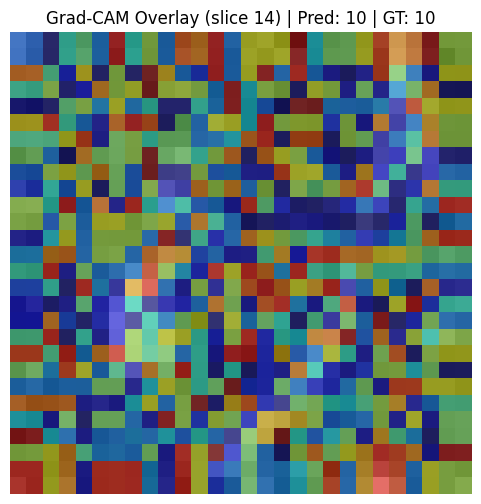

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# === Choose target layer for GradCAM ===
target_layer = 'ltb3.conv.0'  # Change if needed
cam_extractor = GradCAM(model, target_layer=target_layer)

# === Load 1 test sample ===
inputs, targets = next(iter(test_loader))
input_tensor = inputs[0].unsqueeze(0).to(device)  # [1, 1, D, H, W]
true_label = targets[0].item()

# === Forward pass & CAM extraction ===
with torch.set_grad_enabled(True):
    scores = model(input_tensor)
    pred_class = scores.argmax(dim=1).item()
    cams = cam_extractor(pred_class, scores)  # list of CAMs

# === Get the CAM tensor ===
cam = cams[0]  # Could be [1, D, H, W] or [D, H, W]
if cam.dim() == 3:
    cam = cam.unsqueeze(0).unsqueeze(0)  # → [1, 1, D, H, W]
elif cam.dim() == 4:
    cam = cam.unsqueeze(0)               # → [1, 1, D, H, W]
# Else: already fine

# === Interpolate CAM to input shape ===
target_shape = input_tensor.shape[2:]  # [D, H, W]
cam_upsampled = F.interpolate(cam, size=target_shape, mode="trilinear", align_corners=False)

cam_volume = cam_upsampled.squeeze().cpu()  # [D, H, W]

# === Get input volume ===
input_volume = input_tensor.squeeze().cpu()  # [D, H, W]

# === Pick a middle slice ===
slice_idx = input_volume.shape[0] // 2
input_slice = input_volume[slice_idx]  # [H, W]
cam_slice = cam_volume[slice_idx]      # [H, W]

# === Normalize both slices ===
input_norm = (input_slice - input_slice.min()) / (input_slice.max() - input_slice.min() + 1e-6)
cam_norm = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min() + 1e-6)

# === Convert to PIL images ===
input_pil = to_pil_image(input_slice)
cam_pil = to_pil_image(cam_slice)

# Convert grayscale input to RGB for overlay
input_pil = input_pil.convert("RGB")

# === Overlay CAM ===
overlay = overlay_mask(input_pil, cam_pil, alpha=0.5)

# === Plot ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM Overlay (slice {slice_idx}) | Pred: {pred_class} | GT: {target_class}")
plt.axis("off")
plt.show()


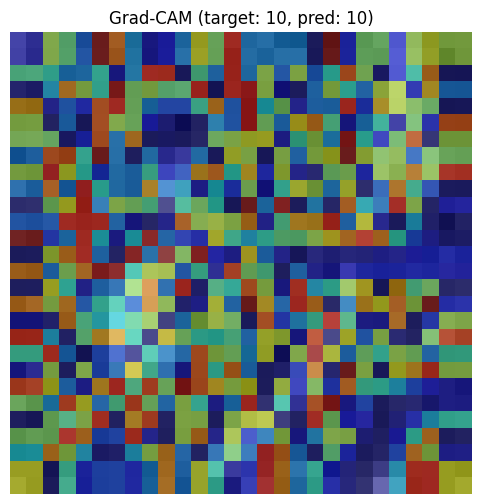

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# === Prepare your model ===
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose a target layer name from your model — ltb3 is good
target_layer = "ltb3"

# Initialize GradCAM
cam_extractor = GradCAM(model, target_layer=target_layer)

# === Pick one test sample ===
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
input_tensor = inputs[0].unsqueeze(0)  # [1, C, D, H, W]
target_class = targets[0].item()

# === Forward pass and CAM generation ===
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Generate CAM
cams = cam_extractor(pred_class, output)
cam = cams[0]

if cam.dim() == 3:
    cam = cam.unsqueeze(0).unsqueeze(0)  # → [1, 1, D, H, W]
elif cam.dim() == 4:
    cam = cam.unsqueeze(0)               # → [1, 1, D, H, W]
# === Interpolate CAM to match input size ===
target_shape = input_tensor.shape[2:]  # [D, H, W]
cam_upsampled = F.interpolate(cam, size=target_shape, mode="trilinear", align_corners=False)

cam_volume = cam_upsampled.squeeze().cpu()  # [D, H, W]


# === Normalize input volume ===
input_volume = input_tensor.squeeze().cpu()  # [D, H, W]
input_volume = (input_volume - input_volume.min()) / (input_volume.max() - input_volume.min())

# === Choose center slice ===
slice_idx = input_volume.shape[0] // 2
input_slice = input_volume[slice_idx]  # [H, W]
cam_slice = cam_volume[slice_idx]      # [H, W]

# Normalize CAM slice
cam_slice = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min())

# Convert grayscale input to RGB for overlay
input_pil = input_pil.convert("RGB")

# === Overlay CAM ===
overlay = overlay_mask(input_pil, cam_pil, alpha=0.5)

# === Plot result ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM (target: {target_class}, pred: {pred_class})")
plt.axis('off')
plt.show()
